# Performance Python
Chapter 8 of Python for Finance. 

Hilpisch, Yves. Python for Finance: Analyze Big Financial Data (Kindle Locations 8343-8347). O'Reilly Media. Kindle Edition. 

Throughout this chapter, we compare the performance of different implementations of the same algorithms. 
To make the comparison a bit easier, we define a convenience function that allows us to systematically compare the performance of different functions executed on the same or different data sets:

In [19]:
def perf_comp_data(func_list, data_list, rep = 3, number = 1): 
    ''' Function to compare the performance of different functions. 
    Parameters = = = = = = = = = = 
    func_list : list list with function names as strings 
    data_list : list list with data set names as strings 
    rep : int 
    number : int number of executions for every function ''' 
    
    from timeit import repeat 
    
    res_list = {} 
    for name in enumerate(func_list): 
        stmt = name[1] + '(' + data_list[name[0]] + ')' 
        setup = "from __main__ import " + name[1] + ', ' + data_list[name[0]] 
        results = repeat(stmt = stmt, setup = setup, repeat = rep, number = number) 
        res_list[name[1]] = sum(results) / rep 
    
    res_sort = sorted(res_list.items(), key = lambda kv: (kv[1],kv[0])) 
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print('function: ' + item[0] + ', av. time sec: %9.5f, ' % item[1]  + 'relative: %6.1f' % rel)

Evaluating this complicated numerical expression on an array of 500,000 numbers:

$$ \sqrt{\left|\cos(x)\right|} + \sin(2+3x)$$

We'll evaluate this expression over the array of 500,000 numbers using the following approaches:
* Standard Python function with explicit looping 
* Iterator approach with implicit looping 
* Iterator approach with implicit looping and using eval 
* NumPy vectorized implementation 
* Single-threaded implementation using numexpr 
* Multithreaded implementation using numexpr

In [2]:
from math import * 
def f(x): 
    return abs(cos(x))** 0.5 + sin(2 + 3 * x)

In [3]:
I = 500000
a_py = range(I)

In [4]:
a_py[50]

50

### Using a loop

In [5]:
def f1(a):
    res=[]
    for x in a:
        res.append(f(x))
    return res

### Iterators and the ```eval``` function

In [6]:
def f2(a):
    return [f(x) for x in a]

In [7]:
def f3(a):
    ex = 'abs(cos(x))**0.5+sin(2+3*x)'
    return [eval(ex) for x in a]

### Using Numpy

In [8]:
import numpy as np
a_np = np.arange(I)

In [9]:
def f4(a):
    return (np.abs(np.cos(a))**0.5+np.sin(2+3*a))

### Using ```numexpr```
Looking at single and multiple threads

In [10]:
import numexpr as ne

In [11]:
def f5(a):
    ex = 'abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

In [12]:
def f6(a):
    ex = 'abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex)

In [13]:
%%time 
r1 = f1(a_py) 
r2 = f2(a_py) 
r3 = f3(a_py) 
r4 = f4(a_np) 
r5 = f5(a_np) 
r6 = f6(a_np)

Wall time: 12.6 s


In [14]:
print('r2: {}'.format(np.allclose(r1,r2)))
print('r3: {}'.format(np.allclose(r1,r3)))
print('r4: {}'.format(np.allclose(r1,r4)))
print('r5: {}'.format(np.allclose(r1,r5)))
print('r6: {}'.format(np.allclose(r1,r6)))

r2: True
r3: True
r4: True
r5: True
r6: True


Comparing the execution time of all 6 different approaches:

In [15]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py', 'a_py', 'a_np', 'a_np', 'a_np']
perf_comp_data(func_list, data_list)

function: f6, av. time sec:   0.00801, relative:    1.0
function: f5, av. time sec:   0.01295, relative:    1.6
function: f4, av. time sec:   0.02394, relative:    3.0
function: f2, av. time sec:   0.49121, relative:   61.3
function: f1, av. time sec:   0.55778, relative:   69.6
function: f3, av. time sec:  11.68514, relative: 1458.6


## Memory layout and performance

In [16]:
import numpy as np
np.zeros((3,3), dtype=np.float64, order='C')

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

When creating numpy arrays, the choice of order (C-like or Fortran-like) makes a difference in performance:

In [17]:
x = np.random.standard_normal((3,1500000))
C = np.array(x, order='C')
F = np.array(x, order='F')
x = 0.0

### Calculation speed with the C-Like order

In [18]:
%timeit C.sum(axis=0)

100 loops, best of 3: 10.9 ms per loop


In [19]:
%timeit C.sum(axis=1)

100 loops, best of 3: 6.26 ms per loop


In [20]:
%timeit C.std(axis=0)

10 loops, best of 3: 47.5 ms per loop


In [21]:
%timeit C.std(axis=1)

10 loops, best of 3: 32.3 ms per loop


### Calculation speed with the Fortran-like order

In [22]:
%timeit F.sum(axis=0)

10 loops, best of 3: 36.1 ms per loop


In [23]:
%timeit F.sum(axis=1)

10 loops, best of 3: 40.8 ms per loop


In [24]:
%timeit F.std(axis=0)

10 loops, best of 3: 120 ms per loop


In [25]:
%timeit F.std(axis=1)

1 loop, best of 3: 215 ms per loop


The Fortran layout is slower for both operations and axes. That's why order='C' is the default.

## Parallel Computing

### Monte Carlo pricing of options

Looking at Black-Scholes-Merton stochastic differential equation:
$$ dS_t = rS_tdt + \sigma S_tdZ_t $$

The Monte Carlo estimator formula:
$$ C_0 = e^{rT} \frac{1}{I}\sum_{I}{max(S_T(i)-K,0)} $$

In [15]:
def bsm_mcs_valuation(strike): 
    ''' Dynamic Black-Scholes-Merton Monte Carlo estimator for European calls. 
    Parameters = = = = = = = = = = 
    strike: float strike price of the option 
    Results = = = = = = = 
    value: float estimate for present value of call option ''' 
    import numpy as np 
    
    S0 = 100.; T = 1.0; r = 0.05; vola = 0.2 
    M = 50; I = 20000 
    dt = T / M 
    rand = np.random.standard_normal(( M + 1, I)) 
    S = np.zeros(( M + 1, I)); S[ 0] = S0 
    
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - 0.5 * vola ** 2) * dt + vola * np.sqrt(dt) * rand[t]) 
    
    value = (np.exp(-r * T) * np.sum(np.maximum( S[-1] - strike, 0)) / I) 
        
    return value

In [27]:
strike = 110.; S0 = 100.; T = 1.0; r = 0.05; vola = 0.2 
M = 50; I = 20000 
dt = T / M 
rand = np.random.standard_normal((M + 1, I)) 
S = np.zeros((M + 1, I)); S[ 0] = S0 

# This will create I "random walks" with 50 steps for the monte carlo simulation 
for t in range(1, M + 1): 
    S[t] = S[t-1] * np.exp((r - 0.5 * vola ** 2) * dt + vola * np.sqrt(dt) * rand[t]) 

value = (np.exp(-r * T) * np.sum( np.maximum(S[-1] - strike, 0)) / I) 

 ...]

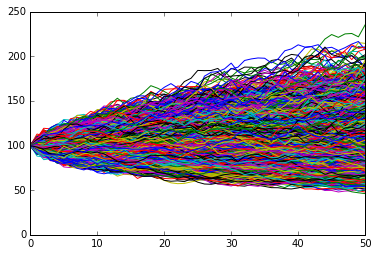

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(S)

### Sequential Valuation

In [29]:
def seq_value(n):
    ''' Sequential option valuation. 
    Parameters = = = = = = = = = = 
    n : int number of option valuations/ strikes ''' 
    
    strikes = np.linspace(80, 120, n) 
    option_values = [] 
    
    for strike in strikes: 
        option_values.append(bsm_mcs_valuation(strike)) 
    
    return strikes, option_values

In [30]:
n = 100 # number of options to value
%time strikes, option_values_seq = seq_value(n)

Wall time: 9.58 s


In [31]:
print('Approximate options valued per second = {:.2f}s'.format(100/4.87))

Approximate options valued per second = 20.53s


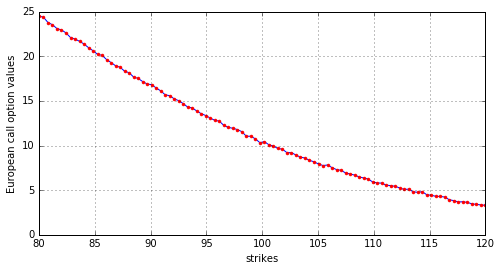

In [32]:
plt.figure(figsize =(8, 4)) 
plt.plot(strikes, option_values_seq, 'b') 
plt.plot(strikes, option_values_seq, 'r.') 
plt.grid(True) 
plt.xlabel('strikes') 
plt.ylabel('European call option values')

### Parallel Valuation

In [33]:
# Before starting the parallel process, need to start the ip cluster by running the following line at a command prompt:
# ipcluster start -n 4

from ipyparallel import Client 
c = Client(profile = "default") 
view = c.load_balanced_view()

In [34]:
def par_value(n): 
    ''' Parallel option valuation. 
    Parameters = = = = = = = = = = 
    n : int number of option valuations/ strikes ''' 
    
    strikes = np.linspace(80, 120, n) 
    option_values = [] 
    
    for strike in strikes:
        value = view.apply_async(bsm_mcs_valuation, strike) 
        option_values.append(value) 
    
    c.wait(option_values) 
    return strikes, option_values

In [35]:
%time strikes, option_values_obj = par_value(n)

Wall time: 2.93 s


In [36]:
print('Approximate options valued per second = {:.2f}s'.format(100/2.77))

Approximate options valued per second = 36.10s


In [37]:
option_values_obj[0].metadata

{'after': [],
 'completed': datetime.datetime(2016, 10, 1, 22, 47, 54, 831084),
 'data': {},
 'engine_id': 1,
 'engine_uuid': '9eedf207-46c0-4476-acf9-0e53f40e7654',
 'error': None,
 'execute_input': None,
 'execute_result': None,
 'follow': [],
 'msg_id': '4d6f1e58-1374-437e-833a-7c5336574e4e',
 'outputs': [],
 'received': datetime.datetime(2016, 10, 1, 22, 47, 54, 837602),
 'started': datetime.datetime(2016, 10, 1, 22, 47, 54, 419491),
 'status': 'ok',
 'stderr': '',
 'stdout': '',
 'submitted': datetime.datetime(2016, 10, 1, 22, 47, 54, 388407)}

In [38]:
option_values_obj[0].get()

24.542313463900452

In [39]:
option_values_obj[0].get()

24.542313463900452

In [40]:
option_values_par = []
for res in option_values_obj:
    option_values_par.append(res.get())

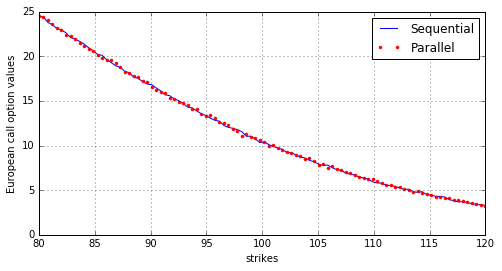

In [41]:
plt.figure(figsize =(8, 4)) 
plt.plot(strikes, option_values_seq, 'b', label='Sequential') 
plt.plot(strikes, option_values_par, 'r.', label='Parallel') 
plt.grid(True) 
plt.legend(loc=0)
plt.xlabel('strikes') 
plt.ylabel('European call option values')

### Performance Comparison

In [42]:
n = 50 # number of option valuations
func_list = ['seq_value','par_value']
data_list = 2*['n']
perf_comp_data(func_list, data_list)

function: par_value, av. time sec:   1.32646, relative:    1.0
function: seq_value, av. time sec:   3.67624, relative:    2.8


##  Multiprocessing
I think this has to be run on a server with 16 cores to match what is in the book. For some reason (maybe not enough cores) it does not run on my 2-core laptop.

In [ ]:
import multiprocessing as mp
import numpy as np

In [ ]:
import math
def simulate_geometric_brownian_motion(p):
    M, I = p
    # time steps, paths
    S0 = 100; r = 0.05; sigma = 0.2; T = 1.0
    # model parameters
    dt = T/M
    paths = np.zeros((M+1, I))
    paths[0] = S0
    
    for t in range(1, M+1):
        paths[t] = paths[t-1] * np.exp((r-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*np.random.standard_normal(I))
    
    return paths

In [ ]:
paths = simulate_geometric_brownian_motion((5,2))
paths

In [ ]:
I = 10000
M = 100
t = 100

In [ ]:
from time import time
times = []

for w in range(1,17):
    t0 = time()
    pool = mp.Pool(processems=w)
    #the pool of workers:
    result = pool.map(simulate_geometric_brownian_motion, t*[(M,I),])
    
    #mapping the function results to the list of parameter tuples:
    times.append(time()-t0)

## Dynamic Compiling
Numba is an open source, NumPy-aware optimizing compiler for Python code. It uses the LLVM compiler infrastructure[ 31] to compile Python byte code to machine code especially for use in the NumPy runtime and SciPy modules.

An example with nested loops:

In [2]:
from math import cos, log 

def f_py(I, J): 
    res = 0 
    for i in range(I): 
        for j in range (J): 
            res += int(cos(log(1))) 
    return res

In [3]:
I, J = 5000, 5000
%time f_py(I,J)

Wall time: 11.8 s


25000000

Vectorizing with NumPy arrays:

In [4]:
import numpy as np
def f_np(I,J):
    a = np.ones((I,J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))), a

In [5]:
%time res, a = f_np(I, J)

Wall time: 560 ms


In [6]:
a.nbytes

200000000

While fast, this approach uses up a lot of memory. Numba can help solve this problem.

In [7]:
import numba as nb

In [8]:
f_nb = nb.jit(f_py)

In [9]:
%time f_nb(I, J)

Wall time: 95.5 ms


25000000

In [10]:
func_list = ['f_py','f_np','f_nb']
data_list = 3*['I, J']
perf_comp_data(func_list, data_list)

function: f_nb, av. time sec:   0.00000, relative:    1.0
function: f_np, av. time sec:   0.53165, relative: 311515.3
function: f_py, av. time sec:  11.74286, relative: 6880587.1


### Binomial Option Pricing

In [11]:
from math import exp, sqrt
# model & option parameters 
S0 = 100. # initial index level 
T = 1. # call option maturity 
r = 0.05 # constant short rate 
vol = 0.20 # constant volatility factor of diffusion 

# time parameters 
M = 1000 # time steps 
dt = T / M # length of time interval 
df = exp(-r * dt) # discount factor per time interval 

# binomial parameters 
u = exp(vol * sqrt(dt)) # up-movement 
d = 1 / u # down-movement 
q = (exp(r * dt) - d) / (u - d) # martingale probability

In [12]:
import numpy as np 

def binomial_py(strike): 
    ''' Binomial option pricing via looping. 
    Parameters = = = = = = = = = = 
    strike : float strike price of the European call option ''' 
    
    # LOOP 1 - Index Levels 
    S = np.zeros((M + 1, M + 1), dtype = np.float64) 
    # index level array 
    S[0, 0] = S0 
    z1 = 0 
    for j in range(1, M + 1, 1):
        z1 += 1 
        for i in range(z1 + 1): 
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2)) 
            
    # LOOP 2 - Inner Values 
    iv = np.zeros((M + 1, M + 1), dtype = np.float64) 
    # inner value array 
    z2 = 0
    for j in range(0, M+1, 1): 
        for i in range(z2+1): 
            iv[i, j] = max(S[i, j] - strike, 0) 
        z2 += 1 
                    
    # LOOP 3 - Valuation 
    pv = np.zeros((M + 1, M + 1), dtype = np.float64) 
    # present value array 
    pv[:, M] = iv[:, M] # initialize last time point
    z3 = M + 1 
    for j in range(M - 1 , -1, -1): 
        z3 = z3 - 1 
        for i in range(z3): 
            pv[i, j] = (q * pv[i, j + 1] + (1 - q) * pv[i + 1, j + 1]) * df
            
    return pv[0, 0]

In [13]:
%time round(binomial_py(100),3)

Wall time: 1.61 s


10.449

In [16]:
%time round(bsm_mcs_valuation(100),3)

Wall time: 52.1 ms


10.295999999999999

In [22]:
def binomial_np( strike): 
    ''' Binomial option pricing with NumPy. 
    Parameters = = = = = = = = = = 
    strike : float strike price of the European call option ''' 
    
    # Index Levels with NumPy 
    mu = np.arange(M + 1) 
    mu = np.resize(mu, (M + 1, M + 1)) 
    md = np.transpose(mu) 
    mu = u ** (mu - md) 
    md = d ** md 
    S = S0 * mu * md 
    
    # Valuation Loop 
    pv = np.maximum(S - strike, 0) 
    z = 0 
    for t in range(M - 1, -1, -1): # backward iteration 
        pv[0: M - z, t] = (q * pv[0: M - z, t + 1] + (1 - q) * pv[ 1: M - z + 1, t + 1]) * df 
        z += 1
    return pv[0, 0]

In [29]:
M = 4 # 4 time steps only
mu = np.arange(M+1)
mu

array([0, 1, 2, 3, 4])

In [30]:
mu = np.resize(mu, (M + 1, M + 1))
mu

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [31]:
md = np.transpose(mu)
md

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [32]:
mu = u**(mu-md)
mu.round(3)

array([[ 1.   ,  1.006,  1.013,  1.019,  1.026],
       [ 0.994,  1.   ,  1.006,  1.013,  1.019],
       [ 0.987,  0.994,  1.   ,  1.006,  1.013],
       [ 0.981,  0.987,  0.994,  1.   ,  1.006],
       [ 0.975,  0.981,  0.987,  0.994,  1.   ]])

In [33]:
md = d**md
md.round(3)

array([[ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
       [ 0.994,  0.994,  0.994,  0.994,  0.994],
       [ 0.987,  0.987,  0.987,  0.987,  0.987],
       [ 0.981,  0.981,  0.981,  0.981,  0.981],
       [ 0.975,  0.975,  0.975,  0.975,  0.975]])

In [34]:
S = S0*mu*md
S.round(3)

array([[ 100.   ,  100.634,  101.273,  101.915,  102.562],
       [  98.743,   99.37 ,  100.   ,  100.634,  101.273],
       [  97.502,   98.121,   98.743,   99.37 ,  100.   ],
       [  96.276,   96.887,   97.502,   98.121,   98.743],
       [  95.066,   95.669,   96.276,   96.887,   97.502]])

In [35]:
M = 1000 # reset number of time steps
%time round(binomial_np(100),3)


Wall time: 153 ms


10.449

In [38]:
import numba as nb
binomial_nb = nb.jit(binomial_py)

In [39]:
%time round(binomial_nb(100),3)

Wall time: 348 ms


10.449

In [40]:
func_list = ['binomial_py','binomial_np','binomial_nb']
K = 100
data_list = 3*['K'] 

In [41]:
perf_comp_data(func_list, data_list)

function: binomial_nb, av. time sec:   0.04145, relative:    1.0
function: binomial_np, av. time sec:   0.12830, relative:    3.1
function: binomial_py, av. time sec:   1.57191, relative:   37.9


## Static Compiling with Cython

In [3]:
def f_py(I, J):
    res = 0. # working with a float object
    for i in range(I):
        for j in range(J*I):
            res += 1
    return res

In [4]:
I, J = 500, 500
%time f_py(I, J)

Wall time: 15 s


125000000.0

### Nested loop with Cython static type declarations

In [13]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [14]:
%%cython
def f_cy(int I, int J):
    cdef double res = 0
    # double float much slower than int or long
    for i in range(I):
        for j in range(J*I):
            res += 1
    return res

In [15]:
%time res = f_cy(I, J)

Wall time: 191 ms


In [16]:
res

125000000.0

In [17]:
import numba as nb
f_nb = nb.jit(f_py)

In [18]:
%time f_nb(I, J)

Wall time: 311 ms


125000000.0

In [20]:
func_list = ['f_py','f_cy','f_nb']
I, J = 500, 500
data_list = 3*['I,J']
perf_comp_data(func_list, data_list)

function: f_nb, av. time sec:   0.18906, relative:    1.0
function: f_cy, av. time sec:   0.18976, relative:    1.0
function: f_py, av. time sec:  14.97294, relative:   79.2


## GPU computing

In [34]:
from numbapro.cudalib import curand
import numpy as np

In [37]:
def get_randoms(x,y):
    rand = np.random.standard_normal((x,y))
    return rand

In [38]:
get_randoms(2,2)

array([[ 1.11657296, -0.25223927],
       [-0.60785832, -0.1033971 ]])

In [40]:
def get_cuda_randoms(x,y):
    rand = np.empty((x*y), np.float64)
        # rand serves as a contaier for the randoms
        # CUDA only fills 1 dimensional arrays
    prng = curand.PRNG(rndtype=curand.PRNG.XORWOW)
        # the argument sets the random number algorithm
    prng.normal(rand,0,1) # filling the container
    rand = rand.reshape((x,y))
        # to be fair we reshape rand to 2 dimensions
    return rand

In [42]:
# get_cuda_randoms(2,2)
# Looks like cuda doesn't run because the CUDA driver library is not loaded